<a href="https://colab.research.google.com/github/jiin124/2021_2_Network-anomaly-detection/blob/main/NSL_KDD_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['KAGGLE_USERNAME']=''
os.environ['KAGGLE_KEY']='

In [3]:
!kaggle datasets download -d kiranmahesh/nslkdd

  0% 0.00/2.56M [00:00<?, ?B/s]
100% 2.56M/2.56M [00:00<00:00, 40.7MB/s]


In [4]:
!unzip '*.zip'

Archive:  nslkdd.zip
  inflating: kdd_test.csv            
  inflating: kdd_train.csv           


In [105]:
train=pd.read_csv("kdd_train.csv")
test=pd.read_csv("kdd_test.csv")

In [106]:
#NULL값으로 채워져있었던 컬럼인 num_out_bound_cmds는 삭제
train.drop('num_outbound_cmds',axis=1,inplace=True)
test.drop('num_outbound_cmds',axis=1,inplace=True)

## labels를 0,1로 바꾸기

normal은 0 나머지 값들은 모두 1로 바꾸어줄것이다.

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [108]:
for i in range(len(train)):
  if train['labels'][i]=='normal':
    train['labels'][i]=0
  else:
    train['labels'][i]=1

In [109]:
train['labels'].value_counts()

0    67343
1    58630
Name: labels, dtype: int64

In [110]:
train=train.astype({'labels':'int'})

In [111]:
for i in range(len(test)):
  if test['labels'][i]=='normal':
    test['labels'][i]=0
  else:
    test['labels'][i]=1

In [112]:
test=test.astype({'labels':'int'})

## train,test로 나누기

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix

In [114]:
x_train = train.drop(columns = 'labels')
y_train = train['labels']
x_test = test.drop(columns = 'labels')
y_test = test['labels']

## object 형식 데이터 원핫인코딩

In [115]:
col = ['protocol_type', 'service', 'flag']

for i in col:
  ohe = pd.get_dummies(x_train[i], prefix=i)
  x_train = pd.concat((x_train, ohe), axis = 1).drop(i, axis = 1)
  ohe = pd.get_dummies(x_test[i], prefix=i)
  x_test = pd.concat((x_test, ohe), axis = 1).drop(i, axis = 1)

In [116]:
for i in x_train.columns:
  count = 0
  for j in x_test.columns:
    if i == j:
      count += 1
  if count == 0:
    x_test[i] = 0

In [117]:
len(x_train.columns)

121

In [118]:
len(x_test.columns)

121

## LGBM 모델링

In [119]:
from lightgbm import LGBMClassifier

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
from lightgbm import LGBMClassifier

lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.1,random_state=0)

evals=[(x_test,y_test)]
lgbm_wrapper.fit(x_train,y_train,early_stopping_rounds=100,eval_metric='logloss',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test)
pred_proba=lgbm_wrapper.predict_proba(x_test)[:,1]

[1]	valid_0's binary_logloss: 0.615147	valid_0's binary_logloss: 0.615147
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.552246	valid_0's binary_logloss: 0.552246
[3]	valid_0's binary_logloss: 0.501039	valid_0's binary_logloss: 0.501039
[4]	valid_0's binary_logloss: 0.456496	valid_0's binary_logloss: 0.456496
[5]	valid_0's binary_logloss: 0.419895	valid_0's binary_logloss: 0.419895
[6]	valid_0's binary_logloss: 0.389591	valid_0's binary_logloss: 0.389591
[7]	valid_0's binary_logloss: 0.36314	valid_0's binary_logloss: 0.36314
[8]	valid_0's binary_logloss: 0.338802	valid_0's binary_logloss: 0.338802
[9]	valid_0's binary_logloss: 0.318396	valid_0's binary_logloss: 0.318396
[10]	valid_0's binary_logloss: 0.301427	valid_0's binary_logloss: 0.301427
[11]	valid_0's binary_logloss: 0.28809	valid_0's binary_logloss: 0.28809
[12]	valid_0's binary_logloss: 0.276833	valid_0's binary_logloss: 0.276833
[13]	valid_0's binary_logloss: 0.267284	valid_0's 

### 정확도 함수

In [24]:
def get_clf_eval(y_test,pred,pred_proba):
  confusion=confusion_matrix(y_test,pred)#오차행렬
  accuracy=accuracy_score(y_test,pred)#정확도
  precision=precision_score(y_test,pred)#정밀도
  recall=recall_score(y_test,pred)#재현율
  f1=f1_score(y_test,pred)
  roc_auc=roc_auc_score(y_test,pred)

  print(confusion)
  print("정확도 :{0:.4f}, 정밀도 : {0:.4f}, 재현율 : {0:.4f}, f1 : {0:.4f},AUC:{4:.4f}".format(accuracy,precision,recall,f1,roc_auc))


In [ ]:
get_clf_eval(y_test,preds,pred_proba)

[[11117   128]
 [ 1546  9753]]
정확도 :0.9257, 정밀도 : 0.9257, 재현율 : 0.9257, f1 : 0.9257,AUC:0.9259


이상한 값을 찾아내고 싶은거니까 재현율이 좀더 높아졌으면 좋겠는데.. 어떻게 높이지


### 피쳐중요도

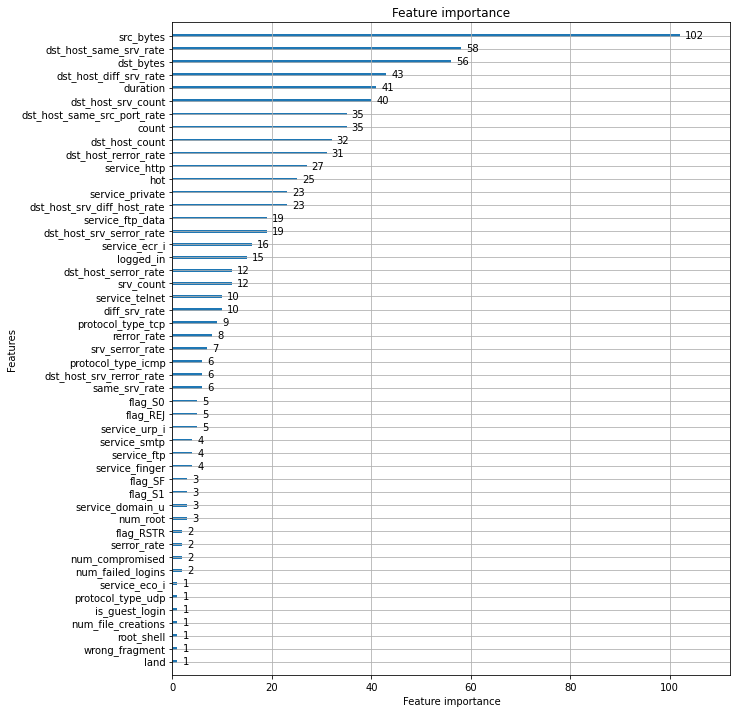

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

In [40]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test,pred_proba_c1):
  #임곗값에 따른 fpr,tpr 값을 반환 받음
  fprs,tprs,thresholds=roc_curve(y_test,pred_proba_c1)

  #roc 곡선을 그래프 곡선으로 그림
  plt.plot(fprs,tprs,label='ROC')

  #가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k--',label='Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X,Y 축 명 설정 등
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR(1-sensitivity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

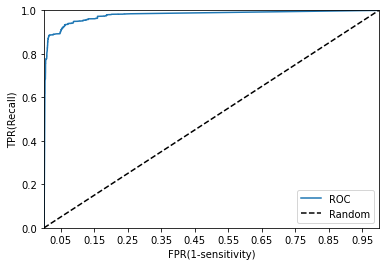

In [ ]:
roc_curve_plot(y_test,pred_proba)

In [22]:
from lightgbm import LGBMClassifier

lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.1,random_state=0)

evals=[(x_test,y_test)]
lgbm_wrapper.fit(x_train,y_train,early_stopping_rounds=100,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test)
pred_proba=lgbm_wrapper.predict_proba(x_test)[:,1]

[1]	valid_0's binary_logloss: 0.615147	valid_0's binary_error: 0.0789567
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.552246	valid_0's binary_error: 0.0817069
[3]	valid_0's binary_logloss: 0.501039	valid_0's binary_error: 0.0900905
[4]	valid_0's binary_logloss: 0.456496	valid_0's binary_error: 0.0872072
[5]	valid_0's binary_logloss: 0.419895	valid_0's binary_error: 0.0859652
[6]	valid_0's binary_logloss: 0.389591	valid_0's binary_error: 0.0869411
[7]	valid_0's binary_logloss: 0.36314	valid_0's binary_error: 0.08805
[8]	valid_0's binary_logloss: 0.338802	valid_0's binary_error: 0.0742991
[9]	valid_0's binary_logloss: 0.318396	valid_0's binary_error: 0.0866306
[10]	valid_0's binary_logloss: 0.301427	valid_0's binary_error: 0.073412
[11]	valid_0's binary_logloss: 0.28809	valid_0's binary_error: 0.0732346
[12]	valid_0's binary_logloss: 0.276833	valid_0's binary_error: 0.074033
[13]	valid_0's binary_logloss: 0.267284	valid_0's binary_error: 

In [25]:
get_clf_eval(y_test,preds,pred_proba)

[[11117   128]
 [ 1546  9753]]
정확도 :0.9257, 정밀도 : 0.9257, 재현율 : 0.9257, f1 : 0.9257,AUC:0.9259


## 하이퍼파라미터 튜닝

In [26]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[400,500],
    'learning_rate':[0.01,0.05,0.1,0.15],
    'max_depth':[3,4,6],
    'colsample_bytree':[0.1,0.5,0.8],
    'subsample':[0.5,0.7]
}

lgbm_clf=LGBMClassifier(random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(lgbm_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.5}
최고 예측 정확도: 0.9992


In [27]:
from lightgbm import LGBMClassifier

lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.5,learning_rate=0.15,
                            max_depth=6,subsample=0.5,random_state=0)

evals=[(x_test,y_test)]
lgbm_wrapper.fit(x_train,y_train,early_stopping_rounds=100,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test)
pred_proba=lgbm_wrapper.predict_proba(x_test)[:,1]

[1]	valid_0's binary_logloss: 0.591607	valid_0's binary_error: 0.12327
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.505295	valid_0's binary_error: 0.0859652
[3]	valid_0's binary_logloss: 0.463919	valid_0's binary_error: 0.0944375
[4]	valid_0's binary_logloss: 0.441227	valid_0's binary_error: 0.0865419
[5]	valid_0's binary_logloss: 0.395509	valid_0's binary_error: 0.0872516
[6]	valid_0's binary_logloss: 0.354935	valid_0's binary_error: 0.0790011
[7]	valid_0's binary_logloss: 0.327381	valid_0's binary_error: 0.0804649
[8]	valid_0's binary_logloss: 0.302251	valid_0's binary_error: 0.0781139
[9]	valid_0's binary_logloss: 0.281134	valid_0's binary_error: 0.0766057
[10]	valid_0's binary_logloss: 0.265179	valid_0's binary_error: 0.0725692
[11]	valid_0's binary_logloss: 0.256713	valid_0's binary_error: 0.0736781
[12]	valid_0's binary_logloss: 0.24752	valid_0's binary_error: 0.0724805
[13]	valid_0's binary_logloss: 0.24102	valid_0's binary_error

In [28]:
get_clf_eval(y_test,preds,pred_proba)

[[11147    98]
 [ 1528  9771]]
정확도 :0.9279, 정밀도 : 0.9279, 재현율 : 0.9279, f1 : 0.9279,AUC:0.9280


튜닝을 하니 조금 나아짐

## 모델 성능 높이기

### 피처중요도가 6이하인 것 모두 삭제

In [120]:
x_train_drop=x_train.drop(['protocol_type_icmp','dst_host_srv_rerror_rate','same_srv_rate','flag_S0',
               'flag_REJ','service_urp_i','service_smtp','service_ftp',
               'service_finger','flag_SF','flag_S1','service_finger',
               'flag_SF','flag_S1','service_domain_u','num_root','flag_RSTR',
               'serror_rate','num_compromised','num_failed_logins',
               'service_eco_i','protocol_type_udp','is_guest_login',
               'num_file_creations','root_shell','wrong_fragment','land'],axis=1)

In [121]:
x_test_drop=x_test.drop(['protocol_type_icmp','dst_host_srv_rerror_rate','same_srv_rate','flag_S0',
               'flag_REJ','service_urp_i','service_smtp','service_ftp',
               'service_finger','flag_SF','flag_S1','service_finger',
               'flag_SF','flag_S1','service_domain_u','num_root','flag_RSTR',
               'serror_rate','num_compromised','num_failed_logins',
               'service_eco_i','protocol_type_udp','is_guest_login',
               'num_file_creations','root_shell','wrong_fragment','land'],axis=1)

In [122]:
from lightgbm import LGBMClassifier


lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.5,learning_rate=0.15,
                            max_depth=6,subsample=0.5,random_state=0)

evals=[(x_test_drop,y_test)]
lgbm_wrapper.fit(x_train_drop,y_train,early_stopping_rounds=100,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_drop)
pred_proba=lgbm_wrapper.predict_proba(x_test_drop)[:,1]

[1]	valid_0's binary_logloss: 0.586569	valid_0's binary_error: 0.107834
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.501076	valid_0's binary_error: 0.085566
[3]	valid_0's binary_logloss: 0.439658	valid_0's binary_error: 0.0839691
[4]	valid_0's binary_logloss: 0.394405	valid_0's binary_error: 0.0829489
[5]	valid_0's binary_logloss: 0.350969	valid_0's binary_error: 0.0818843
[6]	valid_0's binary_logloss: 0.316395	valid_0's binary_error: 0.0772711
[7]	valid_0's binary_logloss: 0.296182	valid_0's binary_error: 0.0790011
[8]	valid_0's binary_logloss: 0.275204	valid_0's binary_error: 0.0759404
[9]	valid_0's binary_logloss: 0.258507	valid_0's binary_error: 0.0772268
[10]	valid_0's binary_logloss: 0.248571	valid_0's binary_error: 0.0766945
[11]	valid_0's binary_logloss: 0.236306	valid_0's binary_error: 0.0746984
[12]	valid_0's binary_logloss: 0.22947	valid_0's binary_error: 0.0730571
[13]	valid_0's binary_logloss: 0.220768	valid_0's binary_erro

In [123]:
get_clf_eval(y_test,preds,pred_proba)

[[11148    97]
 [ 1548  9751]]
정확도 :0.9270, 정밀도 : 0.9270, 재현율 : 0.9270, f1 : 0.9270,AUC:0.9272


피쳐중요도가 떨어지는 것들을 없애니 아주 조금 떨어졌다. 

## 하이퍼파라미터 튜닝

In [35]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[400,500],
    'learning_rate':[0.01,0.05,0.1,0.15],
    'max_depth':[3,4,6],
    'colsample_bytree':[0.1,0.5,0.8],
    'subsample':[0.5,0.7]
}


lgbm_clf=LGBMClassifier(random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(lgbm_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(x_train_drop,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))



최적 하이퍼 파라미터:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.5}
최고 예측 정확도: 0.9991


In [124]:
lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.5,random_states=0)

evals=[(x_test_drop,y_test)]
lgbm_wrapper.fit(x_train_drop,y_train,early_stopping_rounds=200,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_drop)
pred_proba=lgbm_wrapper.predict_proba(x_test_drop)[:,1]

[1]	valid_0's binary_logloss: 0.621973	valid_0's binary_error: 0.102289
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.556842	valid_0's binary_error: 0.106503
[3]	valid_0's binary_logloss: 0.504082	valid_0's binary_error: 0.0884493
[4]	valid_0's binary_logloss: 0.4606	valid_0's binary_error: 0.090401
[5]	valid_0's binary_logloss: 0.423855	valid_0's binary_error: 0.0896026
[6]	valid_0's binary_logloss: 0.39284	valid_0's binary_error: 0.090401
[7]	valid_0's binary_logloss: 0.366247	valid_0's binary_error: 0.0893808
[8]	valid_0's binary_logloss: 0.343856	valid_0's binary_error: 0.0886267
[9]	valid_0's binary_logloss: 0.323587	valid_0's binary_error: 0.086187
[10]	valid_0's binary_logloss: 0.306344	valid_0's binary_error: 0.0798882
[11]	valid_0's binary_logloss: 0.29321	valid_0's binary_error: 0.0815738
[12]	valid_0's binary_logloss: 0.279717	valid_0's binary_error: 0.0833925
[13]	valid_0's binary_logloss: 0.269705	valid_0's binary_error: 0.0

In [125]:
get_clf_eval(y_test,preds,pred_proba)

[[11093   152]
 [ 1539  9760]]
정확도 :0.9250, 정밀도 : 0.9250, 재현율 : 0.9250, f1 : 0.9250,AUC:0.9251


오히려 성능이 좀 떨어진 듯.

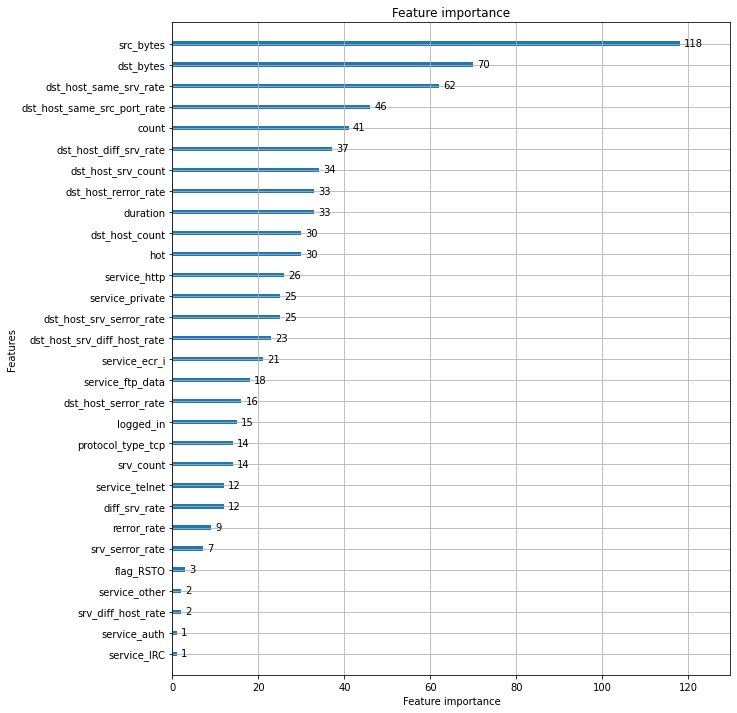

In [41]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

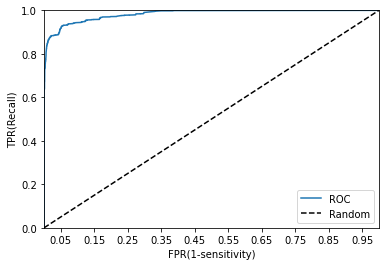

In [42]:
roc_curve_plot(y_test,pred_proba)

## 모델 성능 높이기 - 스케일링

실패

In [ ]:
from sklearn.preprocessing import StandardScaler

x_train_scaled=StandardScaler().fit_transform(x_train)
x_test_scaled=StandardScaler().fit_transform(x_test)

In [ ]:
x_train_scaled=pd.DataFrame(x_train_scaled)
x_test_scaled=pd.DataFrame(x_test_scaled)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.1,random_state=0)

evals=[(x_test_scaled,y_test)]
lgbm_wrapper.fit(x_train_scaled,y_train,early_stopping_rounds=100,eval_metric='logloss',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_scaled)
pred_proba=lgbm_wrapper.predict_proba(x_test_scaled)[:,1]

[1]	valid_0's binary_logloss: 0.630196	valid_0's binary_logloss: 0.630196
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.583943	valid_0's binary_logloss: 0.583943
[3]	valid_0's binary_logloss: 0.551377	valid_0's binary_logloss: 0.551377
[4]	valid_0's binary_logloss: 0.538038	valid_0's binary_logloss: 0.538038
[5]	valid_0's binary_logloss: 0.508738	valid_0's binary_logloss: 0.508738
[6]	valid_0's binary_logloss: 0.487814	valid_0's binary_logloss: 0.487814
[7]	valid_0's binary_logloss: 0.463606	valid_0's binary_logloss: 0.463606
[8]	valid_0's binary_logloss: 0.442339	valid_0's binary_logloss: 0.442339
[9]	valid_0's binary_logloss: 0.430564	valid_0's binary_logloss: 0.430564
[10]	valid_0's binary_logloss: 0.414222	valid_0's binary_logloss: 0.414222
[11]	valid_0's binary_logloss: 0.399844	valid_0's binary_logloss: 0.399844
[12]	valid_0's binary_logloss: 0.394205	valid_0's binary_logloss: 0.394205
[13]	valid_0's binary_logloss: 0.383436	valid_

In [ ]:
get_clf_eval(y_test,preds,pred_proba)

[[ 9950  1295]
 [ 1096 10203]]
정확도 :0.8939, 정밀도 : 0.8939, 재현율 : 0.8939, f1 : 0.8939,AUC:0.8939


## 결정트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(random_state=42)
dt.fit(x_train,y_train)
print(dt.score(x_train,y_train))
print(dt.score(x_test,y_test))

0.999944432537131
0.9135468417317246


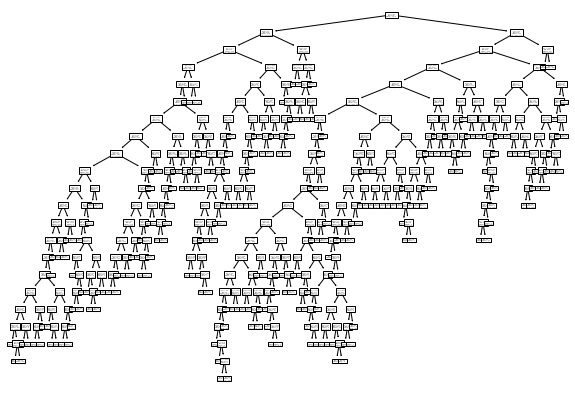

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

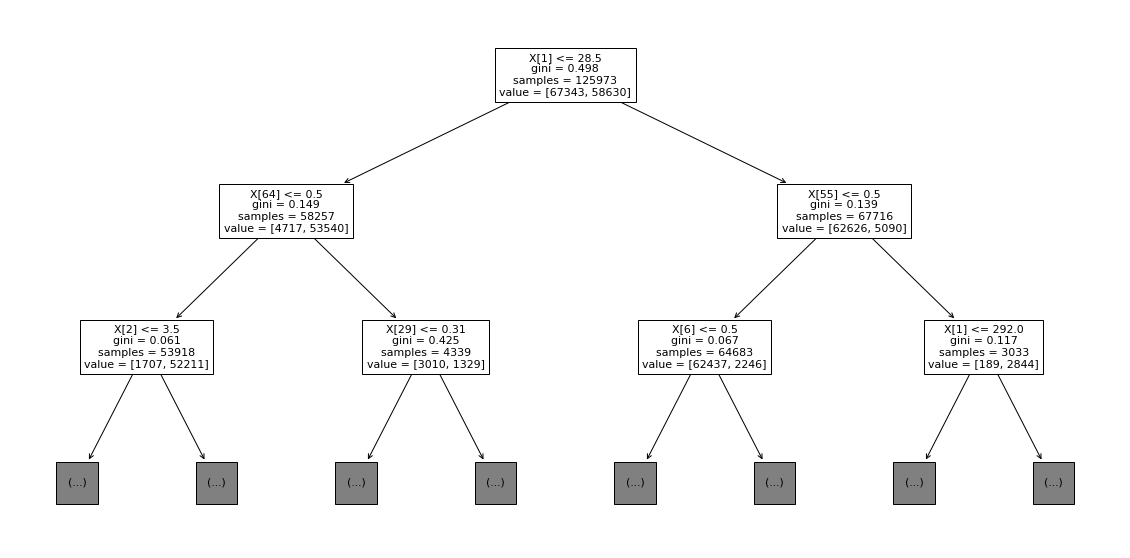

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dt,max_depth=2)
plt.show()

In [ ]:
dt=DecisionTreeClassifier(max_depth=100,random_state=0)
dt.fit(x_train,y_train)
print(dt.score(x_train,y_train))
print(dt.score(x_test,y_test))

0.999944432537131
0.9225958126330731


훈련세트에 과대적합된것을 좀 죽여버려야겠음

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

scores=cross_validate(dt,x_train,y_train,cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.9984996780608594


cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 stratifiedKFold 사용.

In [ ]:
splitter=StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
scores=cross_validate(dt,x_train,y_train,cv=splitter)
print(np.mean(scores['test_score']))

0.9986108175222915


In [ ]:
from sklearn.model_selection import GridSearchCV
params={'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]}
gs=GridSearchCV(DecisionTreeClassifier(random_state=0),params,n_jobs=-1)

In [ ]:
gs.fit(x_train,y_train)
dt=gs.best_estimator_
print(dt.score(x_train,y_train))

0.9959673898375049


In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.99580862 0.99530852 0.99349861 0.99302232 0.99261747]


### 하이퍼 파라미터 튜닝

.... 멍오래걸림

In [ ]:
params={'min_impurity_decrease':np.arange(0.0001,0.001,0.0001),
        'max_depth':range(5,20,1),
        'min_samples_split':range(2,100,10)}

In [ ]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=0),params,n_jobs=-1)
gs.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 12, 'min_impurity_decrease': 0.0001, 'min_samples_split': 2}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.9958165603364015


In [ ]:
dt=gs.best_estimator_
print(dt.score(x_test,y_test))

0.9133694109297374


## lgbm 성능 높이기

### 원래 데이터에 피처중요도가 높은 3가지를 곱해 새로운 컬럼 만들기

In [43]:
x_train_ds=x_train.copy()
x_test_ds=x_test.copy()


In [44]:
x_train_ds['sc_dss']=x_train_ds['src_bytes']*x_train_ds['dst_host_same_srv_rate']*x_train_ds['dst_host_same_srv_rate']
x_test_ds['sc_dss']=x_test_ds['src_bytes']*x_test_ds['dst_host_same_srv_rate']*x_test_ds['dst_host_same_srv_rate']

In [45]:
lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.1,random_state=0)

evals=[(x_test_ds,y_test)]
lgbm_wrapper.fit(x_train_ds,y_train,early_stopping_rounds=200,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_ds)
pred_proba=lgbm_wrapper.predict_proba(x_test_ds)[:,1]

[1]	valid_0's binary_logloss: 0.615918	valid_0's binary_error: 0.0851668
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.551147	valid_0's binary_error: 0.0882718
[3]	valid_0's binary_logloss: 0.499906	valid_0's binary_error: 0.077005
[4]	valid_0's binary_logloss: 0.456596	valid_0's binary_error: 0.0815738
[5]	valid_0's binary_logloss: 0.420602	valid_0's binary_error: 0.0850781
[6]	valid_0's binary_logloss: 0.390384	valid_0's binary_error: 0.0919092
[7]	valid_0's binary_logloss: 0.36412	valid_0's binary_error: 0.0873847
[8]	valid_0's binary_logloss: 0.342463	valid_0's binary_error: 0.0856991
[9]	valid_0's binary_logloss: 0.322528	valid_0's binary_error: 0.087917
[10]	valid_0's binary_logloss: 0.304898	valid_0's binary_error: 0.0826384
[11]	valid_0's binary_logloss: 0.290177	valid_0's binary_error: 0.0805536
[12]	valid_0's binary_logloss: 0.278141	valid_0's binary_error: 0.0821948
[13]	valid_0's binary_logloss: 0.268924	valid_0's binary_erro

In [46]:
get_clf_eval(y_test,preds,pred_proba)

[[11112   133]
 [ 1595  9704]]
정확도 :0.9233, 정밀도 : 0.9233, 재현율 : 0.9233, f1 : 0.9233,AUC:0.9235


### 피처 중요도가 6이하인 것들을 삭제한 데이터에 피처 중요도가 높은 것들의 곱을 해서 새로운 컬럼 만들기

In [47]:
x_train_drop['sc_dss']=x_train_drop['src_bytes']*x_train_drop['dst_host_same_srv_rate']*x_train_drop['dst_host_same_srv_rate']
x_test_drop['sc_dss']=x_test_drop['src_bytes']*x_test_drop['dst_host_same_srv_rate']*x_test_drop['dst_host_same_srv_rate']

In [49]:
lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.1,
                            max_depth=6,subsample=0.1,random_state=0)

evals=[(x_test_drop,y_test)]
lgbm_wrapper.fit(x_train_drop,y_train,early_stopping_rounds=200,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_drop)
pred_proba=lgbm_wrapper.predict_proba(x_test_drop)[:,1]

[1]	valid_0's binary_logloss: 0.617486	valid_0's binary_error: 0.0903123
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.554086	valid_0's binary_error: 0.0810859
[3]	valid_0's binary_logloss: 0.502324	valid_0's binary_error: 0.0806423
[4]	valid_0's binary_logloss: 0.458139	valid_0's binary_error: 0.0820174
[5]	valid_0's binary_logloss: 0.421093	valid_0's binary_error: 0.0848563
[6]	valid_0's binary_logloss: 0.389512	valid_0's binary_error: 0.08805
[7]	valid_0's binary_logloss: 0.363947	valid_0's binary_error: 0.0881388
[8]	valid_0's binary_logloss: 0.342237	valid_0's binary_error: 0.0884049
[9]	valid_0's binary_logloss: 0.322396	valid_0's binary_error: 0.0854773
[10]	valid_0's binary_logloss: 0.305259	valid_0's binary_error: 0.081973
[11]	valid_0's binary_logloss: 0.291814	valid_0's binary_error: 0.0833481
[12]	valid_0's binary_logloss: 0.279931	valid_0's binary_error: 0.0833481
[13]	valid_0's binary_logloss: 0.269926	valid_0's binary_erro

In [50]:
get_clf_eval(y_test,preds,pred_proba)

[[11110   135]
 [ 1498  9801]]
정확도 :0.9276, 정밀도 : 0.9276, 재현율 : 0.9276, f1 : 0.9276,AUC:0.9277


In [51]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[400,500],
    'learning_rate':[0.01,0.05,0.1,0.15],
    'max_depth':[3,4,6],
    'colsample_bytree':[0.1,0.5,0.8],
    'subsample':[0.5,0.7]
}


lgbm_clf=LGBMClassifier(random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(lgbm_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(x_train_drop,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.5}
최고 예측 정확도: 0.9991


In [60]:
lgbm_wrapper=LGBMClassifier(n_estimators=500,colsample_bytree=0.8,learning_rate=0.15,
                            max_depth=6,subsample=0.5,random_state=0)

evals=[(x_test_drop,y_test)]
lgbm_wrapper.fit(x_train_drop,y_train,early_stopping_rounds=200,eval_metric='error',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(x_test_drop)
pred_proba=lgbm_wrapper.predict_proba(x_test_drop)[:,1]

[1]	valid_0's binary_logloss: 0.581868	valid_0's binary_error: 0.0902679
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.499058	valid_0's binary_error: 0.0805536
[3]	valid_0's binary_logloss: 0.436256	valid_0's binary_error: 0.0790454
[4]	valid_0's binary_logloss: 0.386432	valid_0's binary_error: 0.0786018
[5]	valid_0's binary_logloss: 0.348418	valid_0's binary_error: 0.0833038
[6]	valid_0's binary_logloss: 0.316735	valid_0's binary_error: 0.0827271
[7]	valid_0's binary_logloss: 0.294342	valid_0's binary_error: 0.0828158
[8]	valid_0's binary_logloss: 0.277264	valid_0's binary_error: 0.0844571
[9]	valid_0's binary_logloss: 0.262875	valid_0's binary_error: 0.0829489
[10]	valid_0's binary_logloss: 0.250908	valid_0's binary_error: 0.0794003
[11]	valid_0's binary_logloss: 0.239226	valid_0's binary_error: 0.0796221
[12]	valid_0's binary_logloss: 0.232244	valid_0's binary_error: 0.0786462
[13]	valid_0's binary_logloss: 0.22818	valid_0's binary_er

In [61]:
get_clf_eval(y_test,preds,pred_proba)

[[11100   145]
 [ 1408  9891]]
정확도 :0.9311, 정밀도 : 0.9311, 재현율 : 0.9311, f1 : 0.9311,AUC:0.9312


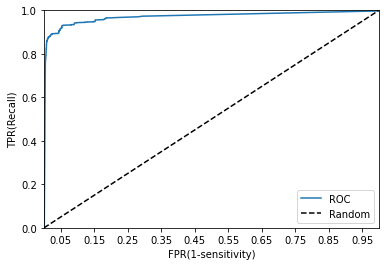

In [62]:
roc_curve_plot(y_test,pred_proba)

In [86]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

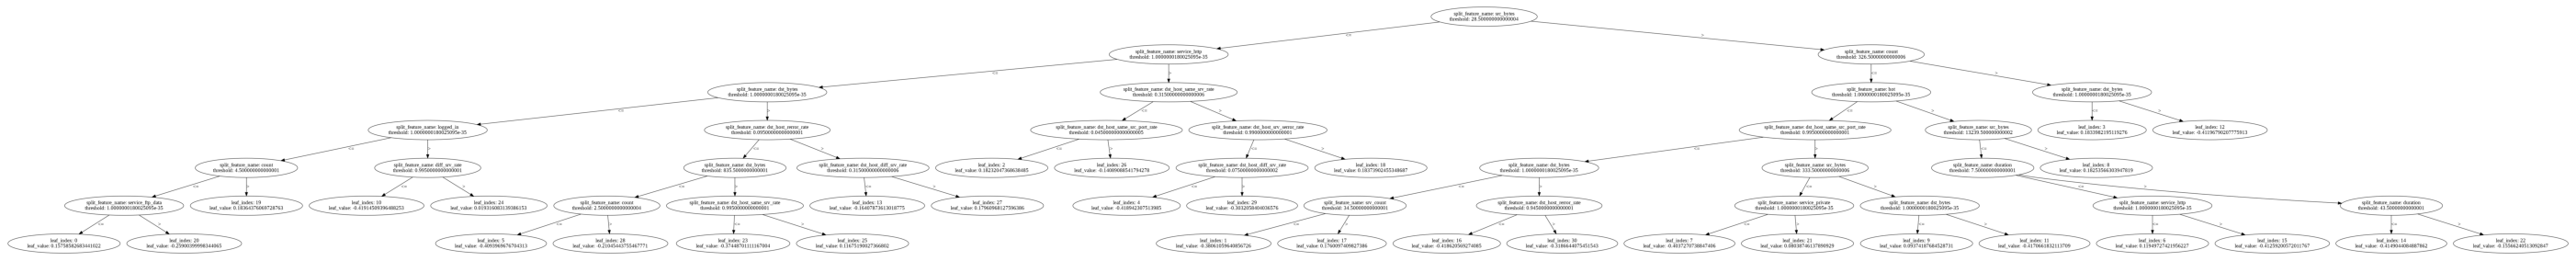

In [101]:

lgb.plot_tree(lgbm_wrapper,figsize=(50,100),tree_index=0)


In [103]:
graph = lgb.create_tree_digraph(lgbm_wrapper,tree_index=0)
graph.render(view=True)

'Digraph.gv.pdf'

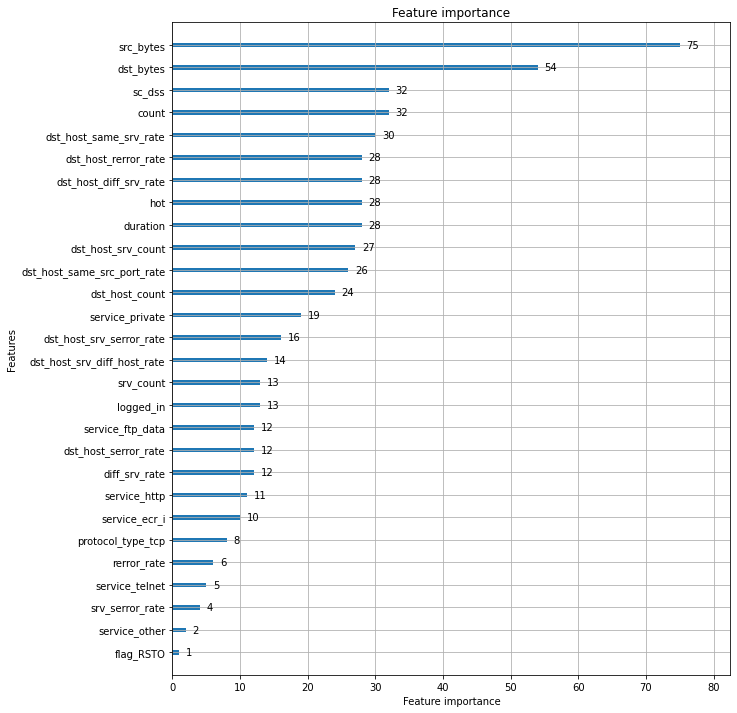

In [104]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)